# Imports and Setups

In [ ]:
!nvidia-smi

Thu Dec  3 14:09:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%capture
!pip install wandb

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Download and Prepare Dataset

In [ ]:
trainloader = tfds.load("plant_village", split='train', as_supervised=False)

Shuffling and writing examples to /root/tensorflow_datasets/plant_village/1.0.2.incompleteI3EFSE/plant_village-train.tfrecord


Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


In [ ]:
BATCH_SIZE = 16
AUTO = tf.data.experimental.AUTOTUNE

def preprocess(data):
    img = tf.image.convert_image_dtype(data['image'], tf.float32)
    return img

trainloader = (
    trainloader
    .shuffle(1024)
    .map(preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

### Visualize Images

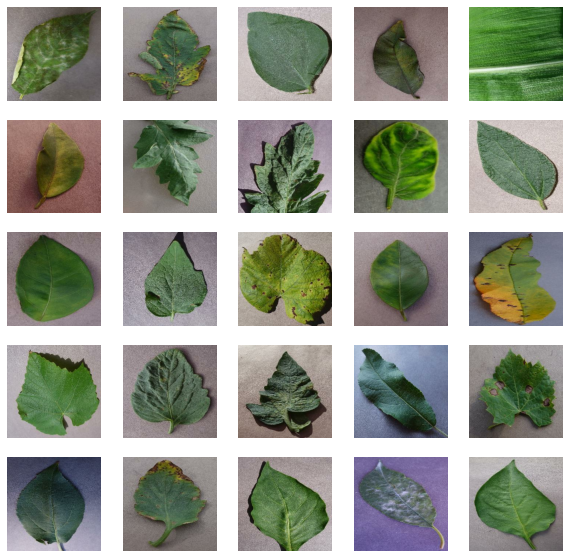

In [ ]:
def show_batch(image_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')

img_batch = []
while len(img_batch)<25:
   batch = next(iter(trainloader))
   img_batch.extend(batch)

show_batch(img_batch)

# Model

#### Generator

In [ ]:
def build_generator():
    latent_input = Input(shape=(256,))
    x = Dense(16*16*256, use_bias=False)(latent_input)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Reshape((16, 16, 256))(x)

    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    gen_image = Conv2D(3, (3,3), strides=(1,1), padding='same', use_bias=False, activation='tanh')(x)

    return Model(latent_input, gen_image)

In [ ]:
tf.keras.backend.clear_session()
generator = build_generator()
generator.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 65536)             16777216  
_________________________________________________________________
batch_normalization (BatchNo (None, 65536)             262144    
_________________________________________________________________
re_lu (ReLU)                 (None, 65536)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 256)       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 256)      

#### Discriminator

In [ ]:
def build_discriminator():
    image_input = Input(shape=(256,256,3))

    x = Conv2D(256, (5, 5), strides=(2, 2), padding='same')(image_input)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(32, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    output = Dense(1)(x)

    return Model(image_input, output)

In [ ]:
tf.keras.backend.clear_session()
discriminator = build_discriminator()
discriminator.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 256)     19456     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 256)     0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       819328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 128)      

# Training Loop

#### Loss


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### Optim

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### Train step

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

#### Callback

In [ ]:
class GeneratedImageLogger(tf.keras.callbacks.Callback):
    def __init__(self):
      super(GeneratedImageLogger, self).__init__()
      self.noise = tf.random.normal([32, 256])

    def on_epoch_end(self, logs, epoch):
      generated_image = generator(self.noise, training=False)

      wandb.log({"gen_images": [wandb.Image(image)
                            for image in generated_image]})

#### Train Loop

In [ ]:
def train(dataset, epochs, gen_image_logger):
  for epoch in range(epochs):
    gen = []
    disc = []
    for step, image_batch in enumerate(dataset):
      gen_loss, disc_loss = train_step(image_batch)
      gen.append(gen_loss)
      disc.append(disc_loss)

      if step%10==0:
          wandb.log({'batch_gen_loss': gen_loss, 'batch_disc_loss': disc_loss})

    print ('Epoch: {}, gen_loss: {}, disc_loss: {}'.format(epoch + 1, np.mean(gen), np.mean(disc)))
    wandb.log({'Epoch': epoch, 'disc_loss': np.mean(disc), 'gen_loss': np.mean(gen)})

    gen_image_logger.on_epoch_end(None, epoch)

# Train with W&B 

In [ ]:
EPOCHS = 200
noise_dim = 256

# initialize wandb run
wandb.init(entity='ayush-thakur', project='gan-zoo')

# initialize model
tf.keras.backend.clear_session()
generator = build_generator()
discriminator = build_discriminator()

# initialize callback
gen_image_logger = GeneratedImageLogger()

# train
train(trainloader, EPOCHS, gen_image_logger)

wandb.finish()

wandb: Currently logged in as: wandb (use `wandb login --relogin` to force relogin)


Epoch: 1, gen_loss: 2.6847152709960938, disc_loss: 0.8236582279205322


In [ ]:
generator.save('dcgan_generator.h5')
discriminator.save('dcgan_discriminator.h5')

In [ ]:
run = wandb.init(entity='ayush-thakur', project='gan-zoo', job_type='producer')

artifact = wandb.Artifact('dcgan_model', type='model')

artifact.add_file('dcgan_generator.h5')
artifact.add_file('dcgan_discriminator.h5')

run.log_artifact(artifact)
run.join()